**This ipynb contains process of data exploration and visualization that helps us make inference on deciding which of the 2 ridesharing company is better for the consumer.**

Time frame of data: 26th Nov 2018 to 19th Dec 2018 (24 days)

Location: Boston, MA

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [5]:
GLstats = pd.read_csv('cab_rides.csv')

<b> Rain Impact with linear regression, random forest, gradient boosting, and KNN </b>


Performing rain impact analysis for Lyft...



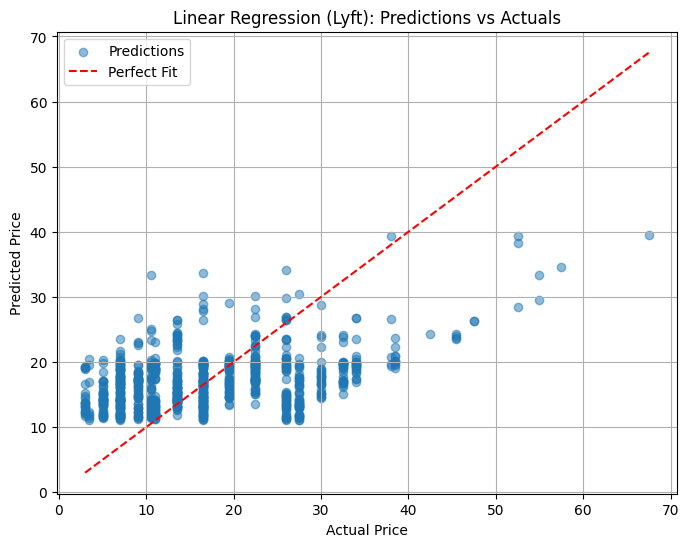

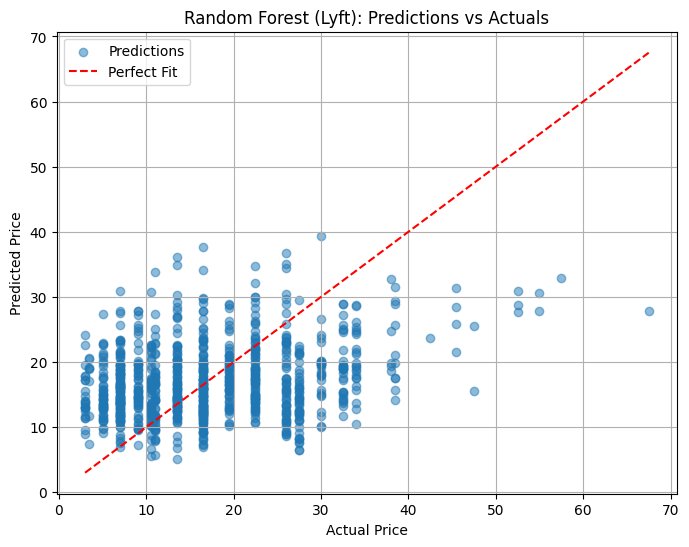

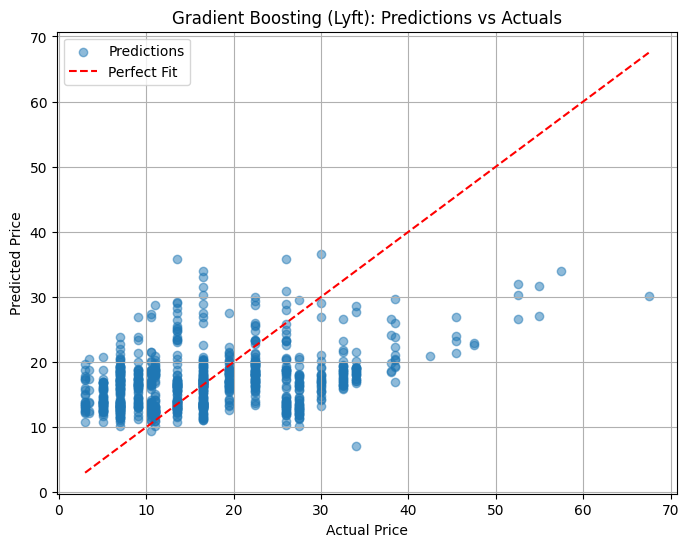

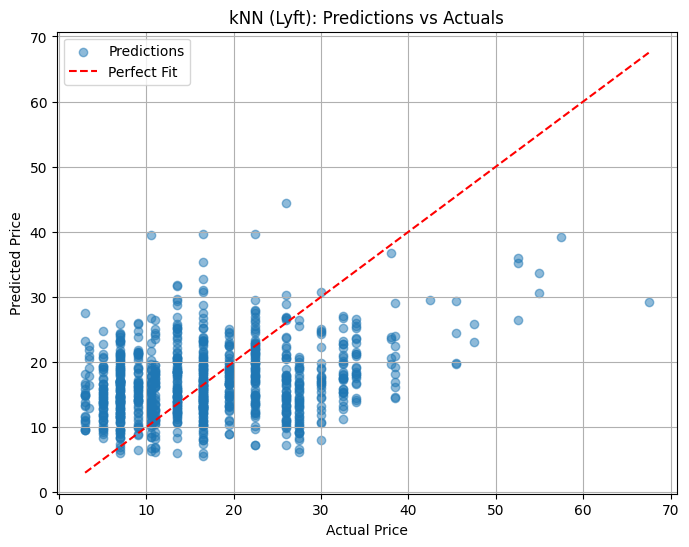


Performance Metrics for Lyft:

                         MSE        R2
Linear Regression  77.235512  0.193262
Random Forest      95.314737  0.004422
Gradient Boosting  83.012457  0.132921
kNN                94.840404  0.009376

Performing rain impact analysis for Uber...



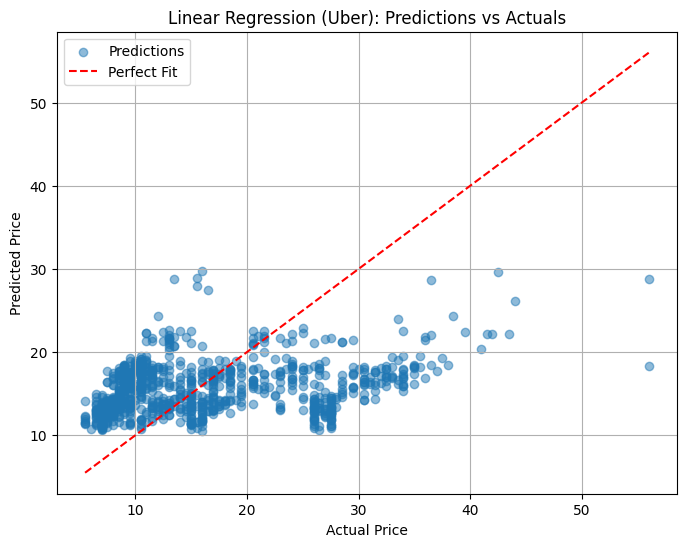

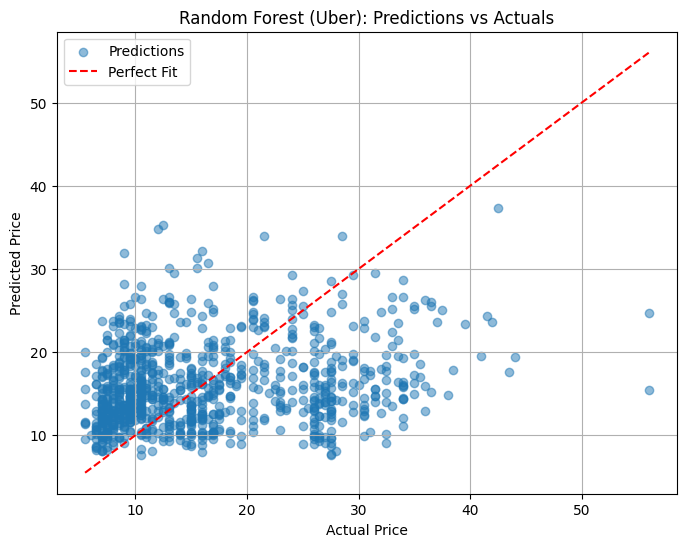

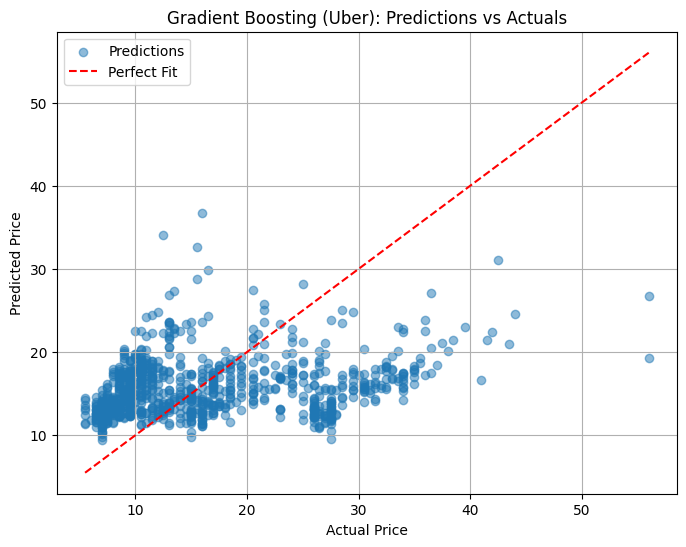

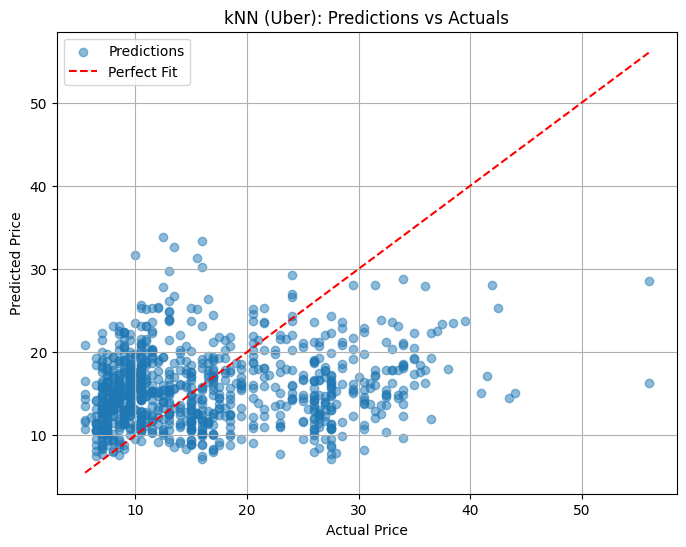


Performance Metrics for Uber:

                         MSE        R2
Linear Regression  67.919604  0.090813
Random Forest      81.267886  -0.08787
Gradient Boosting  71.249085  0.046244
kNN                81.140924  -0.08617


In [17]:
# Updated feature set to include impactful variables
features = [
    'precipIntensity', 'temperature', 'humidity', 'windSpeed', 'visibility',
    'distance', 'surge_multiplier', 'hour'
]
target = 'price'

# Define function to perform rain impact analysis for Lyft or Uber
def perform_rain_impact_analysis(data, service_type):
    print(f"\nPerforming rain impact analysis for {service_type}...\n")
    
    # Filter data for the specific service
    filtered_data = data[data['cab_type'] == service_type][features + [target]].dropna()
    
    # Splitting the dataset
    X = filtered_data[features]
    y = filtered_data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "kNN": KNeighborsRegressor(n_neighbors=5)
    }
    
    # Training and evaluating models
    results = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {"MSE": mse, "R2": r2, "Predictions": y_pred}
        
        # Plot Predictions vs Actuals (1 graph per model)
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
        plt.title(f"{name} ({service_type}): Predictions vs Actuals")
        plt.xlabel("Actual Price")
        plt.ylabel("Predicted Price")
        plt.legend()
        plt.grid()
        plt.show()
    
    # Display performance metrics
    performance_df = pd.DataFrame(results).T[["MSE", "R2"]]
    print(f"\nPerformance Metrics for {service_type}:\n")
    print(performance_df.to_string())

# Perform rain impact analysis for Lyft (4 graphs) and Uber (4 graphs)
perform_rain_impact_analysis(GLstats, "Lyft")
perform_rain_impact_analysis(GLstats, "Uber")


<b>
Insights
</b>

Lyft vs Uber:

Lyft has slightly better performance overall, especially in Linear Regression and Gradient Boosting.
Uber's metrics indicate that its prices are harder to predict using the given features, with lower R² scores and higher errors.

Impact of Additional Features:

Including distance, surge_multiplier, and hour improved Linear Regression and Gradient Boosting models slightly, but the other models still underperform.
Rain-related features like precipIntensity seem to have limited explanatory power when predicting prices.

Best Performing Models:

For Lyft: Linear Regression (R² = 0.19, MSE = 77.24).
For Uber: Gradient Boosting (R² = 0.05, MSE = 71.25).

Feature Relevance:

Weather features alone (e.g., precipIntensity, humidity) has limited impact on prices, suggesting other factors play larger roles.
Demand-related features (surge_multiplier, hour) appear more impactful.

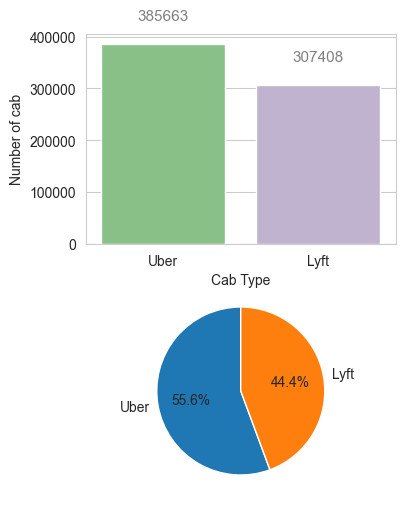

In [3]:
sns.set_style('whitegrid')
f, axes = plt.subplots(2, 1, figsize=(4, 6))

# Histogram (Barplot)
x = ['Uber', 'Lyft']
y = [GLstats.cab_type[(GLstats.cab_type) == 'Uber'].count(),
     GLstats.cab_type[(GLstats.cab_type) == 'Lyft'].count()]

# Corrected barplot syntax
vis1 = sns.barplot(x=x, y=y, palette='Accent', ax=axes[0])
vis1.set(xlabel='Cab Type', ylabel='Number of cab')

# Adding annotations
for p in vis1.patches:
    vis1.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                  textcoords='offset points')

# Pie chart without 'ax' in plt.pie, using axes[1] directly
Ncab_type = [GLstats.cab_type[(GLstats.cab_type) == 'Uber'].count(),
             GLstats.cab_type[(GLstats.cab_type) == 'Lyft'].count()]

cab_type = ['Uber', 'Lyft']

# Plot pie chart on the second subplot
axes[1].pie(Ncab_type, labels=cab_type, startangle=90, autopct='%.1f%%')

plt.show()


Uber gets a more rides compared to Lyft in this particular dataset

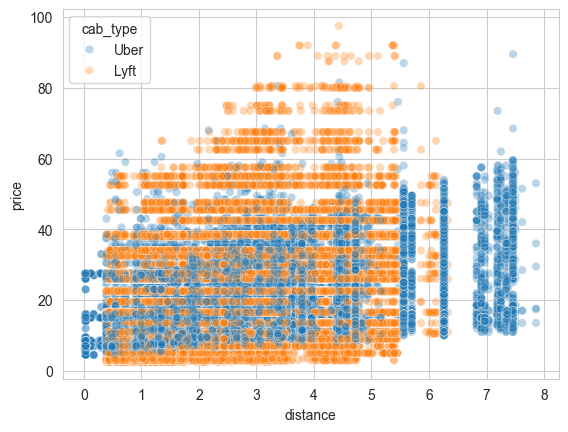

In [4]:
Taxi=GLstats[GLstats.name == 'Taxi'].index
GLstats.drop(Taxi , inplace=True)
vis1=sns.scatterplot(x=GLstats.distance,y=GLstats.price,data=GLstats, hue=GLstats.cab_type, hue_order=cab_type,alpha=0.3, legend='full')

Before showing a general price vs distance chart, drop 'Taxi' from Uber cabs as they use a different fare structure (in the dataset Taxi fare is always 0 USD)
Based on the chart above, it can be observed that Lyft has a lower minimum fare compared to Uber, at the same time Lyft has higher maximum fare. Also, Uber travel distances are generally higher than Lyft.

We also know there is a 'surge multiplier' factor in Lyft, where the fare is multiplied by a certain rate during rush hours.

When prices surge , Uber does not show a multiplier and instead quotes only the higher price up front. Lyft marks up its Prime Time pricing with a percentage: If the rate is 50 percent, a fare that would normally be USD10 costs USD15.
[[source](https://www.nytimes.com/2019/04/17/technology/personaltech/uber-vs-lyft.html)]
This will be verified with the visualization below:

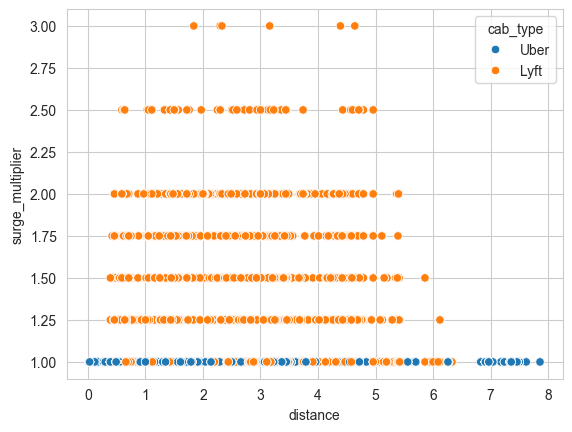

In [5]:
vis1=sns.scatterplot(x=GLstats.distance,y=GLstats.surge_multiplier,data=GLstats, hue=GLstats.cab_type, hue_order=cab_type)

Let's make a quick investigation on the surge trend for Lyft:

In [6]:
LyftOnly=GLstats[GLstats.cab_type == 'Lyft']
A=LyftOnly.groupby(['name','surge_multiplier'],as_index=False).count()
A

,name,surge_multiplier,distance,cab_type,time_stamp,destination,source,price,id,product_id
0,Lux,1.00,47040,47040,47040,47040,47040,47040,47040,47040
1,Lux,1.25,2217,2217,2217,2217,2217,2217,2217,2217
2,Lux,1.50,1013,1013,1013,1013,1013,1013,1013,1013
3,Lux,1.75,484,484,484,484,484,484,484,484
4,Lux,2.00,481,481,481,481,481,481,481,481
5,Lux Black,1.00,47040,47040,47040,47040,47040,47040,47040,47040
6,Lux Black,1.25,2217,2217,2217,2217,2217,2217,2217,2217
7,Lux Black,1.50,1013,1013,1013,1013,1013,1013,1013,1013
8,Lux Black,1.75,484,484,484,484,484,484,484,484
9,Lux Black,2.00,481,481,481,481,481,481,481,481


Except "Shared" type Lyft, most of the Lyft cbs shows a similar number of "surge multiplier" occurence. Chart below will show a rough idea on the occurence rate.

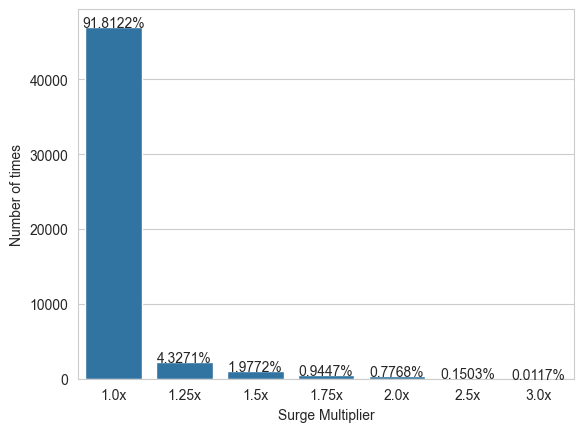

In [7]:
A[:][22:29]
B=A[22:29]['id']
Surge = B
     
Surge_Factor = ['1.0x','1.25x','1.5x','1.75x','2.0x','2.5x','3.0x']

vis1= sns.barplot(x=Surge_Factor,y=B)
vis1.set(xlabel='Surge Multiplier',ylabel='Number of times')

total=sum(B/100)
for p in vis1.patches:
     height = p.get_height()
     vis1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.4f}%'.format(height/total),
            ha="center") 

plt.show()

About 92% of the time, surge does not happen. about 4% 1.25x surge multiplier happens to the fare, 2% for 1.5x surge multiplier and so on. In this case I will multiply the surge multiplier to the initial estimated fare, to show the actual price for Lyft rides.

In [4]:
GLstats2=GLstats.copy()

for i in (list(GLstats2.index.values)):
    if GLstats2.cab_type[i]=='Uber': 
        pass
    elif (GLstats2.cab_type[i]=='Lyft') & (GLstats2.surge_multiplier[i]!=1.0):
        GLstats2.price[i]=(GLstats.price[i] * GLstats2.surge_multiplier[i])

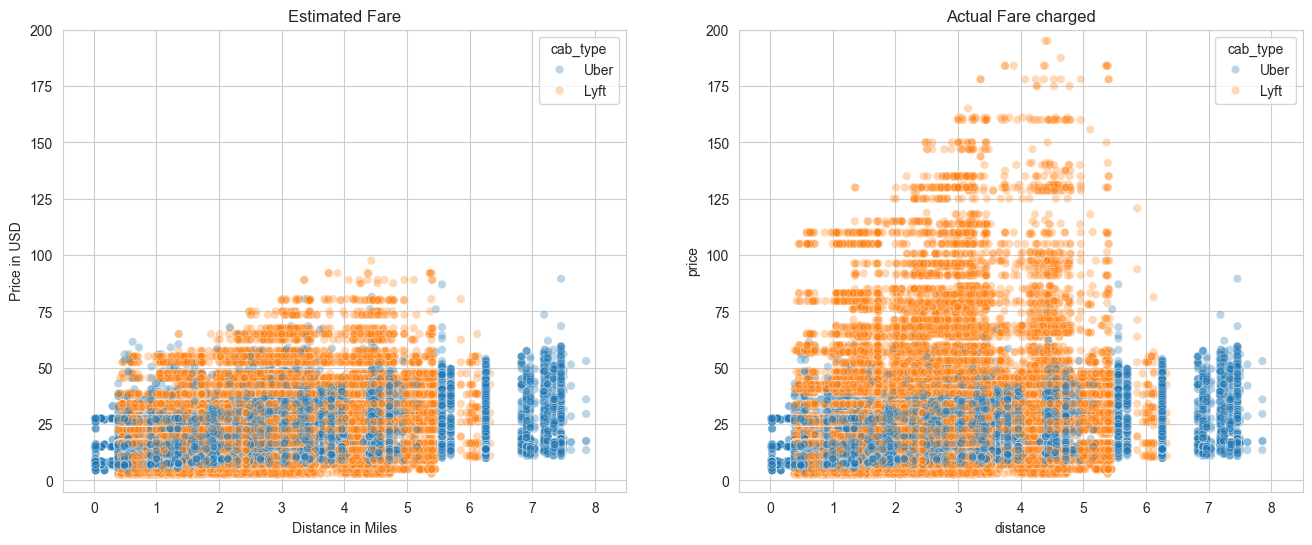

In [5]:
g, axes = plt.subplots (1,2, figsize=(16,6))

vis1=sns.scatterplot(x=GLstats.distance,y=GLstats.price,data=GLstats, hue=GLstats.cab_type, hue_order=cab_type,alpha=0.3, ax=axes[0])

vis2=sns.scatterplot(x=GLstats2.distance,y=GLstats2.price,data=GLstats2, hue=GLstats2.cab_type, hue_order=cab_type, alpha=0.3,ax=axes[1])

vis1.set(xlim=(-0.5, 8.5))
vis1.set(ylim=(-5, 200))
vis2.set(xlim=(-0.5, 8.5))
vis2.set(ylim=(-5, 200))
vis1.set(xlabel='Distance in Miles',ylabel='Price in USD')
vis1.set(xlabel='Distance in Miles',ylabel='Price in USD')


axes[0].set_title('Estimated Fare')
axes[1].set_title('Actual Fare charged')

plt.ioff()

After multiplying with the surge multiplier, Lyft fare shows higher range of fare. Does this means Uber has a better fare rate? The answer is No. I'll prove it in the coming visualizations.
First, let's break down into the types of rides both companies have. As we know there are normal rides, carpool rides, SUV rides, luxury rides etc....each has a different rate.

In [ ]:
h, axes = plt.subplots (1,2, figsize=(12,4))

Ux=GLstats.name[GLstats.cab_type=='Uber'].unique()
Lx=GLstats.name[GLstats.cab_type=='Lyft'].unique()
Uy = GLstats.name[GLstats.name=='UberXL'].count(),GLstats.name[GLstats.name=='Black'].count(),\
     GLstats.name[GLstats.name=='UberX'].count(),GLstats.name[GLstats.name=='WAV'].count(),\
     GLstats.name[GLstats.name=='Black SUV'].count(),GLstats.name[GLstats.name=='UberPool'].count()

Ly=GLstats.name[GLstats.name=='Shared'].count(),GLstats.name[GLstats.name=='Lux'].count(),\
     GLstats.name[GLstats.name=='Lyft'].count(),GLstats.name[GLstats.name=='Lux Black XL'].count(),\
     GLstats.name[GLstats.name=='Lyft XL'].count(),GLstats.name[GLstats.name=='Lux Black'].count()

vis1 = sns.barplot(Ux,Uy,palette='Accent',ax=axes[0])
vis2 = sns.barplot(Lx,Ly,palette='Accent',ax=axes[1])

axes[0].set_title('Number of Uber Rides')
axes[1].set_title('Number of Lyft Rides')
plt.ioff()

TypeError: barplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 2 keyword-only arguments) were given

The dataset has equal number of ride types for both company, with Uber having roughly 5000 more rides than Lyft for each category. Next we will look at the fare for each category.

In [7]:
LyftOnly2=GLstats2[GLstats2.cab_type == 'Lyft']
UberOnly=GLstats2[GLstats2.cab_type == 'Uber']

g, axes = plt.subplots (1,2, figsize=(16,6))

vis1=sns.scatterplot(x=LyftOnly2.distance,y=LyftOnly2.price,data=LyftOnly2, hue=LyftOnly.name, ax=axes[1])
vis2=sns.scatterplot(x=UberOnly.distance,y=UberOnly.price,data=UberOnly, hue=UberOnly.name, ax=axes[0])

vis1.set(xlim=(-0.5, 8.5))
vis1.set(ylim=(-5, 200))
vis2.set(xlim=(-0.5, 8.5))
vis2.set(ylim=(-5, 200))
vis1.set(xlabel='Distance in Miles',ylabel='Price in USD')
vis2.set(xlabel='Distance in Miles',ylabel='Price in USD')


axes[1].set_title('Lift Fare vs Distance by car type')
axes[0].set_title('Uber Fare vs Distance by car type')
plt.ioff()

NameError: name 'LyftOnly' is not defined

Unfortunately the chart looks a little messy and it is difficult to compare, so let's further break down the types of rides.
Based on some online results, we can say the following for both competiting company rides:

**Lyft vs Uber**
* Lyft ordinary ride fare is comparable to UberX
* Lux Black XL is comparable to Black SUV
* Lyft XL is comparable to UberXL
* Shared is comparable to UberPool

At the same time, we will join the intersection of Lyft and Uber rides that shares the same time frame (timestamp) and source & destination. This way it is a fair comparison as we are comparing the exact time/weather/traffic condition from both company.


In [8]:
Join_TDS=UberOnly.merge(LyftOnly2, how='inner',on=['time_stamp','destination','source'])

In [9]:
Join_TDS = Join_TDS.drop(columns=["id_x","product_id_x","id_y","product_id_y","surge_multiplier_x","surge_multiplier_y"])

Further drop other rides that are hard to compare:
WAV= wheelchar accessible (Uber) that is not specified in Lyft
Uber Black which I am not sure to compare with Lyft Lux or Lyft Lux Black

In [10]:
A=Join_TDS[Join_TDS.name_x == 'WAV'].index
Join_TDS.drop(A , inplace=True)
A=Join_TDS[Join_TDS.name_x == 'Black'].index
Join_TDS.drop(A , inplace=True)
A=Join_TDS[Join_TDS.name_y == 'Lux'].index                
Join_TDS.drop(A , inplace=True)
A=Join_TDS[Join_TDS.name_y == 'Lux Black'].index                
Join_TDS.drop(A , inplace=True)


In [11]:
g, axes = plt.subplots (1,2, figsize=(16,6))

U1=['UberX','Black SUV','UberXL','UberPool']
L1=['Lyft','Lux Black XL','Lyft XL','Shared']

vis1=sns.scatterplot(x=Join_TDS.distance_x,y=Join_TDS.price_x,data=Join_TDS,hue='name_x',hue_order=U1,ax=axes[0])
vis2=sns.scatterplot(x=Join_TDS.distance_y,y=Join_TDS.price_y,data=Join_TDS,hue='name_y',hue_order=L1,ax=axes[1])

vis1.set(xlim=(-0.2, 7))
vis1.set(ylim=(-5, 200))
vis2.set(xlim=(-0.2, 7))
vis2.set(ylim=(-5, 200))
vis1.set(xlabel='Distance in Miles',ylabel='Price in USD')
vis2.set(xlabel='Distance in Miles',ylabel='Price in USD')
vis1.set_title('Grab Ride')
vis2.set_title('Lyft Ride')

plt.ioff()

It looks like our first observation still stands, Lyft has a bigger range of fare rate, at the same time lower minumum charge. Let's zoom both chart to the majority data located, which is price below 50 USD

In [12]:
sns.set_style('whitegrid')
g, axes = plt.subplots (2,2, figsize=(14,10))


U1=['UberX','Black SUV','UberXL','UberPool']
L1=['Lyft','Lux Black XL','Lyft XL','Shared']

vis1=sns.scatterplot(x=Join_TDS.distance_x,y=Join_TDS.price_x,data=Join_TDS,hue='name_x',hue_order=U1,ax=axes[1,0])
vis2=sns.scatterplot(x=Join_TDS.distance_y,y=Join_TDS.price_y,data=Join_TDS,hue='name_y',hue_order=L1,ax=axes[1,1])

vis1.set(xlim=(-0.2, 7))
vis1.set(ylim=(-5, 50))
vis2.set(xlim=(-0.2, 7))
vis2.set(ylim=(-5, 50))
vis1.set(xlabel='Distance in Miles',ylabel='Price in USD')
vis2.set(xlabel='Distance in Miles',ylabel='Price in USD')



Ux=['UberX', 'Black SUV', 'UberXL', 'UberPool']
Lx=['Lyft', 'Lux Black XL', 'Lyft XL', 'Shared']
Uy = Join_TDS.name_x[Join_TDS.name_x=='UberX'].count(),Join_TDS.name_x[Join_TDS.name_x=='Black SUV'].count(),\
     Join_TDS.name_x[Join_TDS.name_x=='UberXL'].count(),Join_TDS.name_x[Join_TDS.name_x=='UberPool'].count()

Ly=Join_TDS.name_y[Join_TDS.name_y=='Lyft'].count(),Join_TDS.name_y[Join_TDS.name_y=='Lux Black XL'].count(),\
     Join_TDS.name_y[Join_TDS.name_y=='Lyft XL'].count(),Join_TDS.name_y[Join_TDS.name_y=='Shared'].count()

vis3= sns.barplot(Ux,Uy,ax=axes[0,0])

vis4= sns.barplot(Lx,Ly,ax=axes[0,1])


for p in vis3.patches:
             vis3.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='gray', xytext=(0, 6),
                 textcoords='offset points')
for p in vis4.patches:
             vis4.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='gray', xytext=(0, 6),
                 textcoords='offset points')
        
plt.ioff()


axes[0,0].set_title('Number of Uber Rides')
axes[0,1].set_title('Number of Lyft Rides')
plt.ioff()


plt.legend(bbox_to_anchor=(0.8,0.25))

plt.ioff()

TypeError: barplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

For shared ride ("Shared" for Lyft and "Uberpool' for Uber), Lyft has a cheaper rate compared to Uber.
For other rides, both sides looks similar pretty similar and it is difficult to tell which one is cheaper yet.
So, a boxplot of price per mile travelled vs ride type is plotted:

In [13]:
list(Join_TDS.columns.values)
A = Join_TDS[['time_stamp',
 'destination','source',
'distance_x', 'cab_type_x', 'price_x', 'name_x']]

A.columns=['time_stamp',
 'destination','source',
'distance', 'cab_type', 'price', 'name']

B = Join_TDS[['time_stamp',
 'destination','source',
'distance_y', 'cab_type_y', 'price_y', 'name_y']]

B.columns=['time_stamp',
 'destination','source',
'distance', 'cab_type', 'price', 'name']
FPM=A.append(B)

AttributeError: 'DataFrame' object has no attribute 'append'

In [14]:
FPM['fare_per_mile']= round(FPM.price/FPM.distance,2)

NameError: name 'FPM' is not defined

In [15]:
O1=['UberX', 'Black SUV', 'UberXL', 'UberPool', 'Lyft', 'Lux Black XL',
        'Lyft XL','Shared']

import matplotlib as mpl
sns.set_style('darkgrid')
plt.figure(figsize=(10, 8))

vis1 = sns.boxplot( data = FPM, x = 'name', y = 'fare_per_mile', \
                   showfliers=False, hue='cab_type',order=O1,palette='Set3')


vis1.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
vis1.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

vis1.set_title('Fare($) Per Mile')
vis1.set(xlabel='Cab Type',ylabel='Fare ($) Per Mile')

vis1.grid(b=True, which='major', color='w', linewidth=1)
vis1.grid(b=True, which='minor', color='w', linewidth=0.5)
plt.ioff()


NameError: name 'FPM' is not defined

Lyft has a better rate for carpool category.
Lyft XL has a slightly lower fare per mile than UberXL.
Uber Black SUV shows lower rate than Lyft Black XL.
Lyft ordinary ride and UberX has similar rates, in which Lyft is better up till 3rd quarter of sample.

Next let's look at the time factor that might affect the availability and fare for the rides

In [16]:
import datetime
#convert 13digit time stamp to datetime format
GLstats2['time']= pd.to_datetime(GLstats2['time_stamp'], unit='ms')
#extract hours only
GLstats2['hour']= GLstats2['time'].dt.hour
GLstats2['fare_per_mile']= round(GLstats2.price/GLstats2.distance,2)

#drop unwanted rows that is not comparable
A=GLstats2[GLstats2.name == 'WAV'].index
GLstats2.drop(A , inplace=True)
A=GLstats2[GLstats2.name == 'Black'].index
GLstats2.drop(A , inplace=True)
A=GLstats2[GLstats2.name == 'Lux'].index                
GLstats2.drop(A , inplace=True)
A=GLstats2[GLstats2.name == 'Lux Black'].index                
GLstats2.drop(A , inplace=True)

In [17]:
LyftOnly=GLstats2[GLstats2.cab_type == 'Lyft']
UberOnly=GLstats2[GLstats2.cab_type == 'Uber']

vis1 = sns.distplot(LyftOnly.hour, bins=24,kde=False, color='blue')
vis2 = sns.distplot(UberOnly.hour, bins=24,kde=False,color='yellow')

plt.xticks(range(0, 25,2))
plt.legend(title='cab type', loc='upper left', labels=['Lyft','Uber'],bbox_to_anchor=(1,1))
vis1.set(ylabel='Number of rides')


plt.ioff()

From the distribution we can say that the trend of rides are similar for both company, with Uber having more rides than Lyft.

In [18]:
vis1 = sns.lineplot(x=GLstats2.hour, y=GLstats2.fare_per_mile,\
                    data=GLstats2, hue=GLstats2.name,err_style=None)

plt.xticks(range(0, 25,2))
vis1.set(xlabel='Hour of day',ylabel='Fare ($) per mile')
plt.legend(title='cab type', loc='upper left', labels=['Lyft Shared', 'Lyft','Lyft Lux Black XL','Lyft XL',\
                                                     'UberXL','UberX','Uber Black SUV','UberPool'],bbox_to_anchor=(1,1))

plt.ioff()

This hourly chart gives us the following info:

*From Top*
* **First two pair lines:** The average fare for Lyft Lux Black XL has a less deviation with respect to hour of the day compared to Uber Black SUV
* **2nd line pair:** The average fare per mile for UberXL is more expensive than Lyft XL rides
* **3rd line pair:** Lyft ordinary ride beats UberX ordinary ride in terms of average fare
* **Final pair:** Lyft Shared ride which average about 3USD is cheaper than UberPool that averages above 5USD.

**So far, I infer Lyft rides has a better rate compared to Uber for this particular dataset.**

Future work: 
Day of the week factor
Traffic condition of the given area are not compared exactly, only time is common

In [22]:

import requests
cab_data = pd.read_csv('cab_rides.csv')

# Replace with actual API and key if running this locally
api_url = "https://openexchangerates.org/api/latest.json"  # Replace with actual API
params = {"app_id": "71ae0c8172ed478a95feaf01fd30b4e8", "base": "USD"}
response = requests.get(api_url, params=params)

# Check if response is successful
if response.status_code == 200:
    conversion_rate = response.json().get("rates", {}).get("USD", 1.1) * 1.1  # Assume a 10% increase
    print(f"Conversion rate to 2024 prices: {conversion_rate}")
else:
    print("Error fetching conversion rate. Using default conversion rate of 1.1.")
    conversion_rate = 1.1

# Calculate 2024 prices
cab_data['price_2024'] = cab_data['price'] * conversion_rate

# Display sample of updated data
cab_data[['price', 'price_2024']].head()


Conversion rate to 2024 prices: 1.1


,price,price_2024
0,5.0,5.5
1,11.0,12.1
2,7.0,7.7
3,26.0,28.6
4,9.0,9.9


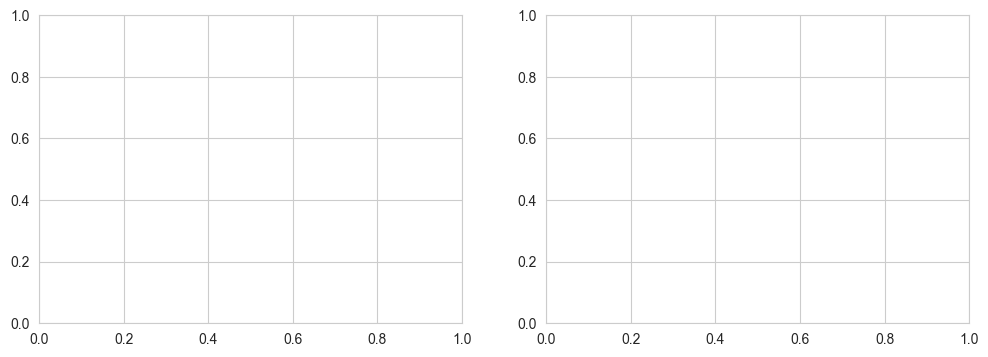

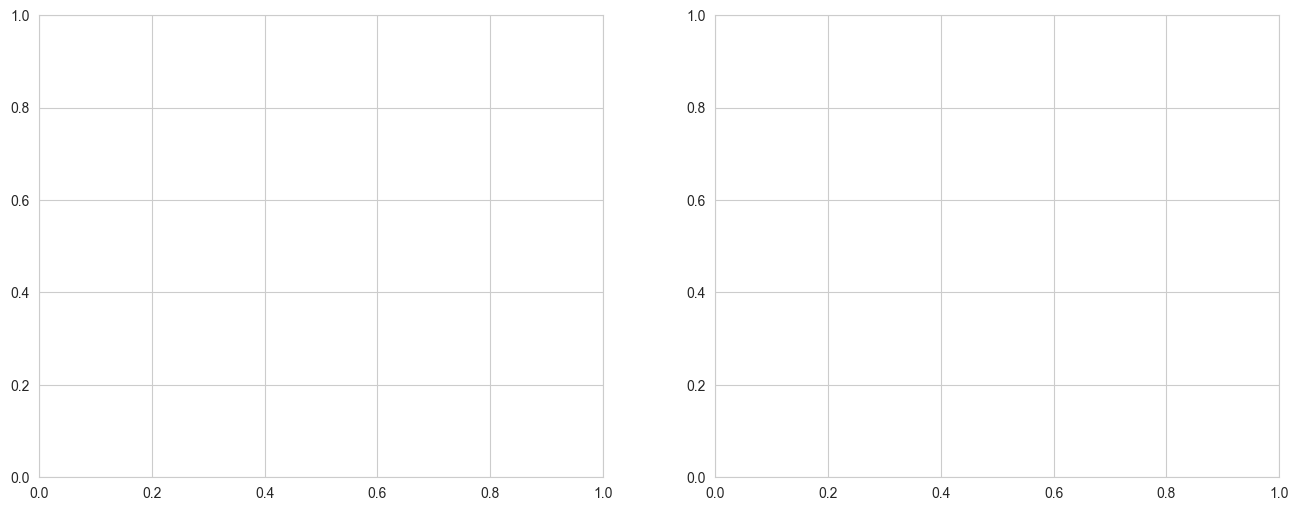

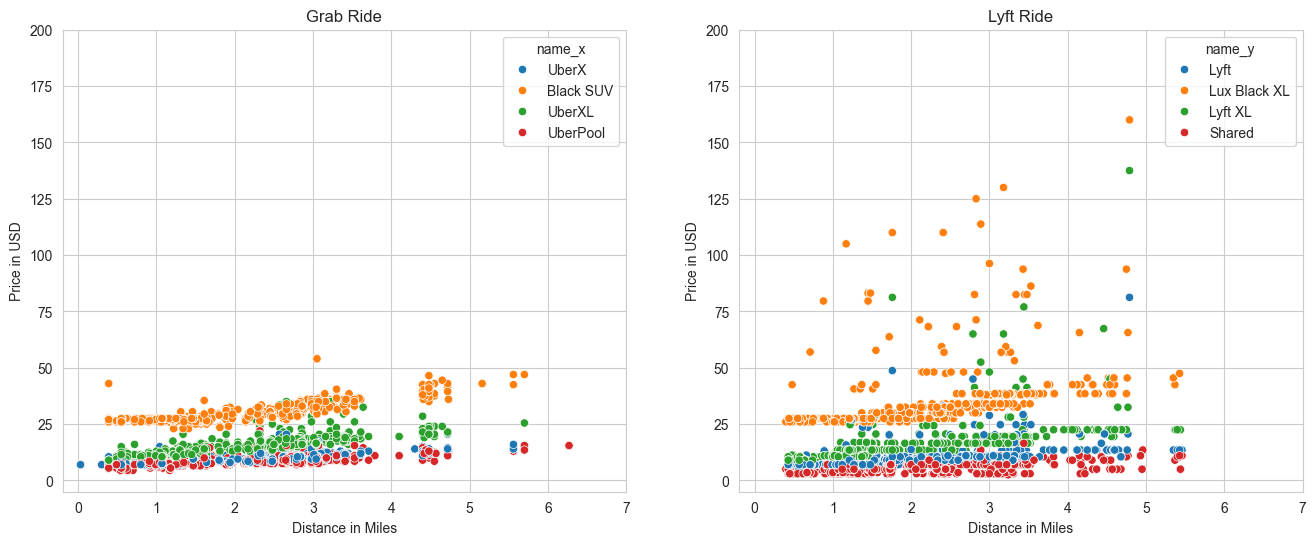

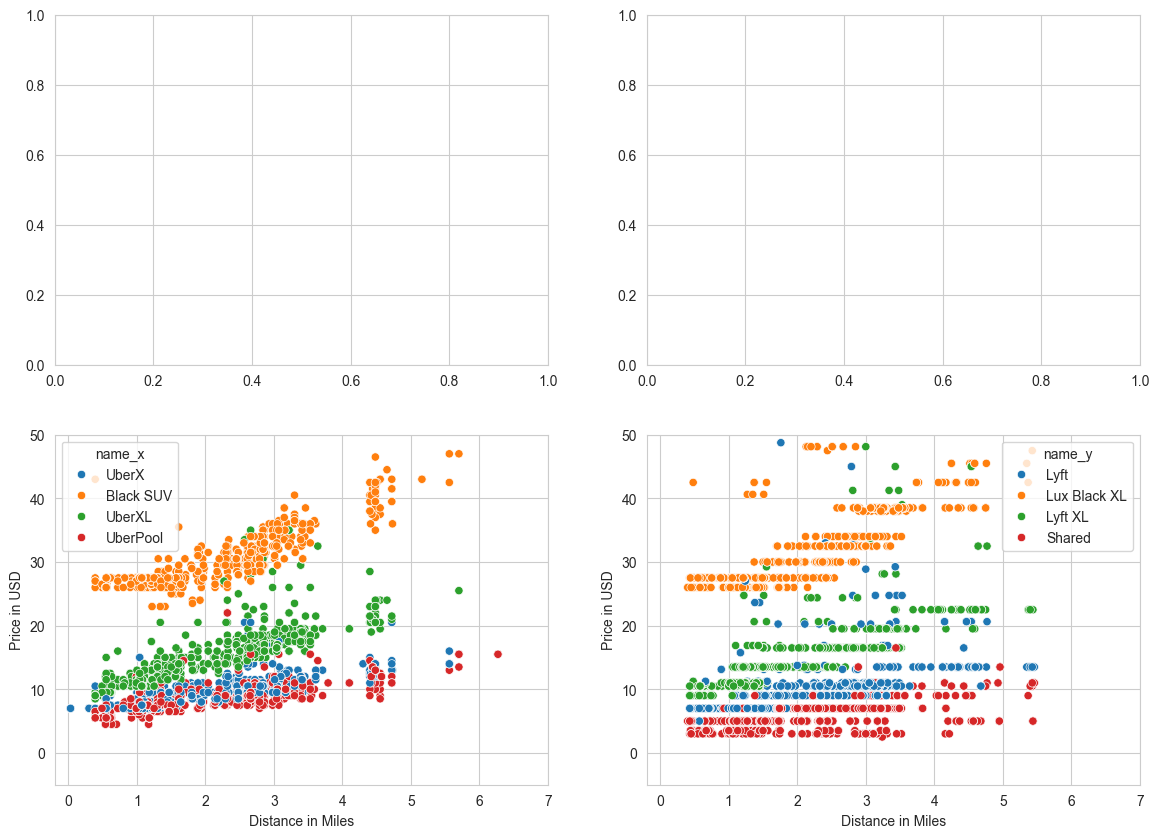

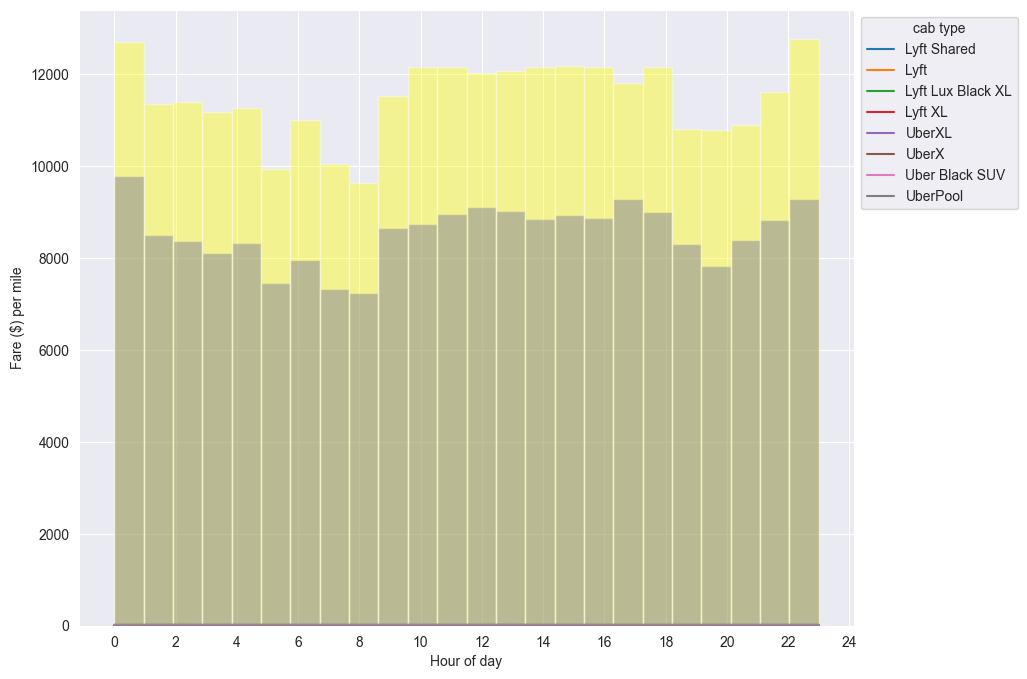

<Figure size 1000x600 with 0 Axes>

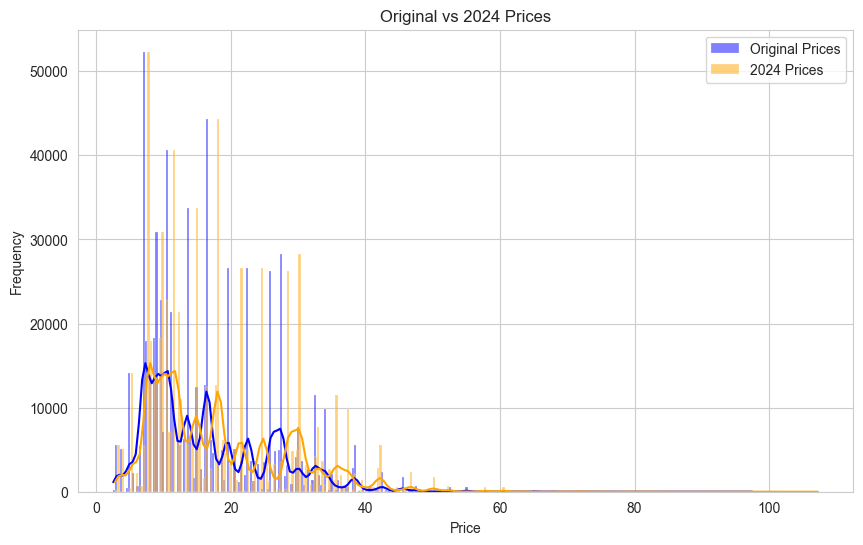

In [23]:

# Visualization of original vs 2024 prices
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))

# Plot a comparison of original and 2024 prices
sns.histplot(cab_data['price'], color='blue', label='Original Prices', kde=True)
sns.histplot(cab_data['price_2024'], color='orange', label='2024 Prices', kde=True)

plt.title('Original vs 2024 Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()
